In [144]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix   
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_digits
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model
from keras.optimizers import SGD
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans

# Diabetes dataset for regression or classification: 
# The goal of the script is to first classify if a patient 
# has diabetes or not based on multiple features like:
#   Patient age
#   Patient sex
#   Patient BMI
#   Patient average blood pressure
#   Six blood serum measurements
# All of these features are measured on 442 patients, and used
# as an indicator of disease progression after one year.

# First we load the dataset
# Here we see that the "x" value represents each person and their
# 10 features. While the "y" values represents each person.
# The diabetes dataset is returned as a "regression" dataset
data = load_diabetes()
x, y = data['data'], data['target']
print(data["feature_names"])
print(x.shape)
print(y.shape)
print(x[0][0])

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
(442, 10)
(442,)
0.0380759064334241


In [145]:
x_train_normal, x_test_normal, y_train_normal, y_test_normal = train_test_split(x, y, test_size=0.2, random_state=42)

# Since the diabetes dataset is loaded as a regression dataset,
# we have to convert it to a classification problem.

# First we create an array of zeros with the same size as "y"
# Then we set each element to 1 in our "y_" array, where in the "y" array
# the correspoding element is bigger than 140. Then we convert the values
# of decimals in "y_" to integers.
y_ = np.zeros(y.shape)
y_[y > 140] = 1.
y_ = y_.astype(int)

# Then we split our data into 80% training data and 20% testing data
# The "random_state" parameter is used for reprodruction of the data. 
# The stratify parameter makes sure that "y_" is equally represented 
# in both training and test. This type of setup is called holdout.
x_train_labeled, x_test_labeled, y_train_labaled, y_test_labaled = train_test_split(x, y_, test_size=0.2, random_state=42, stratify=y_)

In [146]:
# Standardise the data so that all the data has a range between 0 and 1, 
# instead of between -1 and 1. This is to scale our features correctly.
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_train_standarized_labeled = min_max_scaler.fit_transform(x_train_labeled)
x_test_standarized_labeled = min_max_scaler.fit_transform(x_test_labeled)

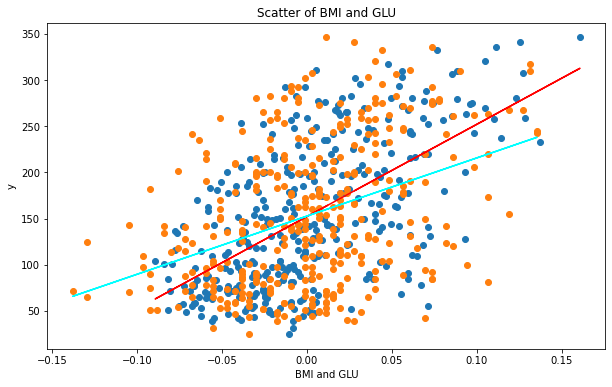

In [147]:
bmi = x_train_normal[:, np.newaxis, 2]
glu = x_train_normal[:, np.newaxis, 9]

y = y_train_normal[:, np.newaxis]

bmi_linear_regression = LinearRegression().fit(bmi, y_train_normal)
bmi_predicted_y = bmi_linear_regression.predict(bmi)

glu_linear_regression = LinearRegression().fit(glu, y_train_normal)
glu_predicted_y = glu_linear_regression.predict(glu)

# Plotting of the regression line on a scatterd plot
plt.figure(figsize=(10,6))
plt.scatter(bmi, y_train_normal)
plt.scatter(glu, y_train_normal)
plt.plot(bmi, bmi_predicted_y, c='r')
plt.plot(glu, glu_predicted_y, c='cyan')
plt.title('Scatter of BMI and GLU')
plt.ylabel('y')
plt.xlabel('BMI and GLU')
plt.show()

In [148]:
def select_features(train_data, y_data, test_data, n_features='all', regression=True):
    score_function = f_regression
    if (regression):
        score_function = chi2

    k_best = SelectKBest(score_func=score_function, k=n_features)
    k_best.fit(train_data, y_data)
    
    x_train_k_best = k_best.transform(train_data)
    x_test_k_best = k_best.transform(test_data)

    return x_train_k_best, x_test_k_best, k_best

def plot_k_best_score(scores):
    plt.bar([i for i in range(len(scores))], scores)
    plt.title('Score value of each feature')
    plt.xlabel('Feature')
    plt.ylabel('Score')
    plt.show()

def pca_features(dataset, transform, n_features=5):
    pca = PCA(n_components=n_features).fit(dataset)

    transformed = pca.transform(transform)

    return transformed, pca

def plot_pca_variance(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('PCA coverage features')
    plt.xlabel('Features')
    plt.ylabel('Coverage')
    plt.show()

def print_percent_correct(predicted, test):
    print('Percentage correct:', 100*np.sum(predicted == test) / len(test))

def plot_matrix(title, matrix):
    cmap = ListedColormap(['darkorange', 'gold', 'blue', 'red'])

    plt.figure()
    plt.matshow(matrix)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(x=j, y=i, s=matrix[i,j], va='center', ha='center')
    
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

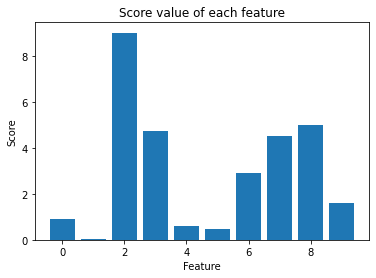

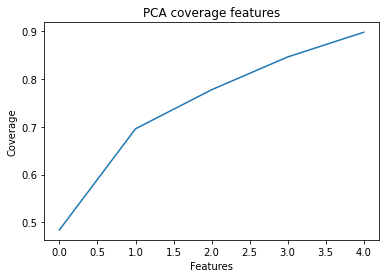

In [149]:
features = 5

x_trainset_features = x_train_standarized_labeled
y_trainset_features = y_train_labaled
x_testset_features = x_test_standarized_labeled

x_train_k_best, x_test_k_best, k_best = select_features(x_trainset_features, y_trainset_features, x_testset_features, n_features=features)
plot_k_best_score(k_best.scores_)

transformed, pca = pca_features(dataset=x_trainset_features, transform=x_trainset_features, n_features=features)
x_train_pca = transformed
transformed, pca = pca_features(dataset=x_trainset_features, transform=x_testset_features, n_features=features)
x_test_pca = transformed
plot_pca_variance(pca)

# VERY IMPORTANT! SET TRAINING DATA HERE!
x_train = x_train_k_best
x_test = x_test_k_best
y_train = y_train_labaled
y_test = y_test_labaled

<Figure size 432x288 with 0 Axes>

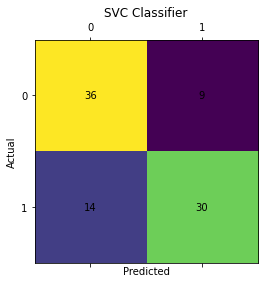

Percentage correct: 74.15730337078652


<Figure size 432x288 with 0 Axes>

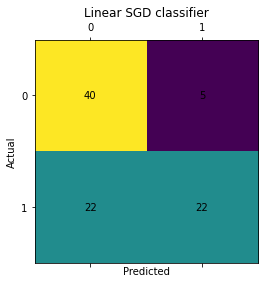

Percentage correct: 69.66292134831461


In [150]:
predicter = Sequential()

predicter.add(Dense(units=features*2, activation='relu', input_dim=features, name='Input'))
predicter.add(Dense(units=10, activation='relu', name='Hidden1'))
predicter.add(Dense(units=5, activation='relu', name='Hidden2'))
predicter.add(Dense(units=1, activation='sigmoid', name='Output'))

predicter.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

svc_clf = SVC(random_state=42,kernel='rbf', C=2200, gamma=0.0001)
svc_clf.fit(x_train, y_train)
y_pred_svc = svc_clf.predict(x_test)
svc_clf.get_params

# Confusion matrix SVC
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_svc)
plot_matrix('SVC Classifier', cm)
print_percent_correct(y_pred_svc, y_test)

# Linear SDG classifier using SVM(Support venctor machine)
sgd_clf = SGDClassifier(random_state=42, max_iter=2000, tol=0.001)
sgd_clf.fit(x_train, y_train)
y_pred_sdg = sgd_clf.predict(x_test)

# Confusion matrix SGD
cm2 = confusion_matrix(y_true=y_test, y_pred=y_pred_sdg)
plot_matrix('Linear SGD classifier', cm2)
print_percent_correct(y_pred_sdg, y_test)

In [151]:
history = predicter.fit(x = x_train, y = y_train, epochs=100, batch_size=64, shuffle=True, validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
6/6 [==============================] - 0s 15ms/step - loss: 0.7183 - accuracy: 0.4986 - val_loss: 0.7120 - val_accuracy: 0.5056
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 0.7136 - accuracy: 0.4986 - val_loss: 0.7088 - val_accuracy: 0.5056
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.7095 - accuracy: 0.4986 - val_loss: 0.7057 - val_accuracy: 0.5056
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 0.7055 - accuracy: 0.4986 - val_loss: 0.7029 - val_accuracy: 0.5056
Epoch 5/100
6/6 [==============================] - 0s 6ms/step - loss: 0.7021 - accuracy: 0.4986 - val_loss: 0.7003 - val_accuracy: 0.5056
Epoch 6/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6991 - accuracy: 0.4958 - val_loss: 0.6978 - val_accuracy: 0.4944
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6964 - accuracy: 0.5042 - val_loss: 0.6956 - val_accuracy: 0.4831
Epoch 8/100
6/6 [=========

[0.9223551  0.07440427 0.09222329 0.8010941  0.45156282 0.6745471
 0.25565815 0.37979555 0.7180201  0.01570266 0.23668239 0.0979276
 0.7430159  0.6864041  0.6044178  0.03389859 0.9284095  0.10745111
 0.03353065 0.37872437 0.0491302  0.05734497 0.16749251 0.6281248
 0.5717035  0.3891985  0.12779629 0.02622312 0.05441141 0.31018063
 0.44089824 0.75311685 0.72865915 0.3001951  0.73110265 0.59843624
 0.71425015 0.42587057 0.09431237 0.6256531  0.842331   0.5555402
 0.79569423 0.323792   0.2697364  0.7260552  0.38028634 0.3991779
 0.80752206 0.10869688 0.9007998  0.02915388 0.48789293 0.08090317
 0.56932974 0.34862593 0.85234183 0.0290013  0.39627576 0.2096996
 0.8755171  0.6711963  0.35151812 0.58198094 0.33497158 0.41512525
 0.8309556  0.11793339 0.25734234 0.59665024 0.13926062 0.90079546
 0.7647567  0.12002876 0.5498204  0.59773445 0.92779213 0.18329802
 0.20462847 0.63485014 0.12258112 0.03887242 0.12636387 0.8459129
 0.48720273 0.6245038  0.05296457 0.7184776  0.51696855]
[1. 0. 0. 1.

<Figure size 432x288 with 0 Axes>

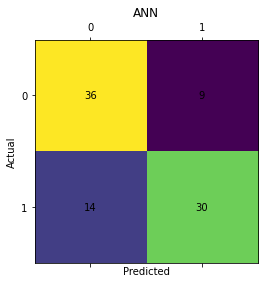

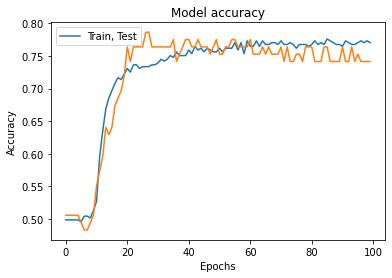

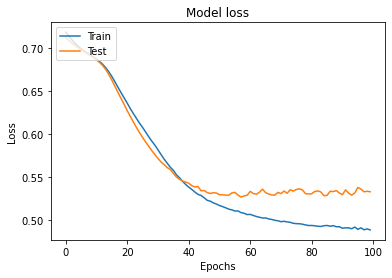

In [152]:
pr = predicter.predict(x_test)
pr_reformed = pr[:,0]
print(pr_reformed)
pr_transformed = np.zeros(len(pr))
pr_transformed[pr_reformed > 0.5] = 1
print(pr_transformed)

ann_cm = confusion_matrix(y_true=y_test, y_pred=pr_transformed)
plot_matrix('ANN', ann_cm)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Accuracy: 74.15730337078652


<Figure size 432x288 with 0 Axes>

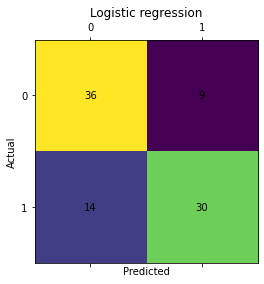

In [153]:
model = LogisticRegression(penalty = 'l2', random_state = 0)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred)*100)

cm = confusion_matrix(y_test, y_pred)
plot_matrix('Logistic regression', cm)

0.7640449438202247


<Figure size 432x288 with 0 Axes>

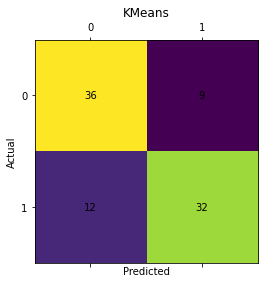

In [154]:
k_means = KMeans(n_clusters=2, max_iter=100, algorithm='auto', random_state=42, verbose=0)
k_means.fit(x_train)
k_means_predicted = k_means.predict(x_test)
print(accuracy_score(y_test, k_means_predicted))
k_means_cm = confusion_matrix(y_true=y_test, y_pred = k_means_predicted)
plot_matrix('KMeans', k_means_cm)